# =========================
# Notebook 4: Feature Engineering + Modeling
# =========================

In [70]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [71]:
# Step 2: Load dataset with sentiment
df = pd.read_csv("/Users/sangsthitapanda/Desktop/L&T PROJECT/archive/employee_attrition_with_sentiment.csv")
print("Shape:", df.shape)


Shape: (10000, 29)


In [72]:
# Step 3: Drop non-useful columns
df = df.drop(columns=["employee_id", "feedback_text"], errors="ignore")

In [73]:
# Step 4: Define features and target
X = df.drop("attrition", axis=1)
y = df["attrition"]

In [74]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (8000, 26) Test size: (2000, 26)


In [75]:
# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object']).columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

In [76]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("✅ Preprocessing complete!")


✅ Preprocessing complete!


# -----------------------------
# Hyperparameter tuning
# -----------------------------

In [77]:
# Random Forest tuning
rf = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf,
    rf_param_dist,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_train_processed, y_train)
best_rf = rf_search.best_estimator_
print("Best RF params:", rf_search.best_params_)

Best RF params: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [83]:
# XGBoost tuning
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42
)
xgb_param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb,
    xgb_param_dist,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

xgb_search.fit(X_train_processed, y_train)
best_xgb = xgb_search.best_estimator_
print("Best XGB params:", xgb_search.best_params_)

Best XGB params: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [84]:
# Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

In [85]:
# -----------------------------
# Evaluate models
# -----------------------------
models = {
    "Logistic Regression": log_reg,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

results = {}
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n📊 {name} Results:")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))


📊 Logistic Regression Results:
Accuracy: 0.506
              precision    recall  f1-score   support

           0       0.79      0.52      0.63      1601
           1       0.19      0.46      0.27       399

    accuracy                           0.51      2000
   macro avg       0.49      0.49      0.45      2000
weighted avg       0.67      0.51      0.56      2000


📊 Random Forest Results:
Accuracy: 0.8005
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1601
           1       0.00      0.00      0.00       399

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000


📊 XGBoost Results:
Accuracy: 0.8005
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1601
           1       0.00      0.00      0.00       399

    accuracy                           0.80      2000


/Users/sangsthitapanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sangsthitapanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sangsthitapanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le


📊 Ensemble (Voting Classifier) Results:
Accuracy: 0.8005
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1601
           1       0.00      0.00      0.00       399

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000



/Users/sangsthitapanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sangsthitapanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sangsthitapanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

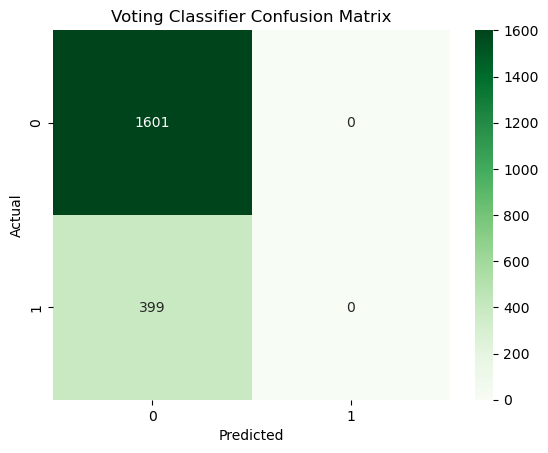

In [86]:

# Ensemble (Voting Classifier)
voting_clf = VotingClassifier(
    estimators=[
        ("log_reg", log_reg),
        ("rf", best_rf),
        ("xgb", best_xgb)
    ],
    voting="soft"
)
voting_clf.fit(X_train_processed, y_train)
y_pred_voting = voting_clf.predict(X_test_processed)
results["Voting Classifier"] = accuracy_score(y_test, y_pred_voting)

print("\n📊 Ensemble (Voting Classifier) Results:")
print("Accuracy:", results["Voting Classifier"])
print(classification_report(y_test, y_pred_voting))

cm = confusion_matrix(y_test, y_pred_voting)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Voting Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [87]:
# -----------------------------
# Save the best model
# -----------------------------
best_model_name = max(results, key=results.get)
print("\n🏆 Best model:", best_model_name, "with accuracy:", results[best_model_name])

if best_model_name == "Logistic Regression":
    best_model = log_reg
elif best_model_name == "Random Forest":
    best_model = best_rf
elif best_model_name == "XGBoost":
    best_model = best_xgb
else:
    best_model = voting_clf

joblib.dump(best_model, "models/best_attrition_model.pkl")
print("✅ Best model saved!")



🏆 Best model: Random Forest with accuracy: 0.8005
✅ Best model saved!
